In [1]:
from transformers import AutoTokenizer
import torch 
import joblib 
import numpy as np
import pickle
import string
import os
import re
import glob
from torch.nn import functional as F
from scipy.spatial.distance import hamming
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import natsort
import seaborn as sns
from natsort import os_sorted
import sys
from scipy import stats
sys.path.append('/home/jianing/generation/Memory_generation')
from utils import calculate_cross_entropy,normalize_entropy,model_to_path_dict

from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
import sys
sys.path.append('/home/jianing/generation/Memory_generation')
from utils import get_segmentation_indices,segmentation_to_word_list

def story_segmentation_indices(story,model):
    segmentation_dir=os.path.join('/home/jianing/generation/behavior_data/segmentation',story)
    consensus_path = os.path.join(segmentation_dir,'%s_consensus.txt'%story)
    original_transcript_dir = '/home/jianing/generation/transcripts/moth_stories'
    with open(consensus_path,'r') as f:
        consensus_txt = f.read()
    consensus_txt = consensus_txt.split('\n')
    consensus_wordlist = segmentation_to_word_list(consensus_txt)

    with open(os.path.join(original_transcript_dir,'%s.txt'%story),'r') as f:
        original_txt = f.read()

    # load story tokens
    tokens_dir = os.path.join('/home/jianing/generation/generated',model,'moth_stories_output')
    story_tokens = torch.load(os.path.join(tokens_dir,story,'tokens.pkl')) # this contains BOS token
    with open(os.path.join(tokens_dir,story,'tokenized_txt.pkl'),'rb') as f:
        tokenized_txt = pickle.load(f)
    with open(os.path.join(tokens_dir,story,'cross_entropy.pkl'),'rb') as f:
        story_ce = pickle.load(f)
    # humans segment after this token index in tokenized_txt
    segmentation_indices_in_tokens = get_segmentation_indices(tokenized_txt,consensus_wordlist,original_txt,initial_char='Ġ')
    assert segmentation_indices_in_tokens[-1] == len(tokenized_txt)-1,'last segmentation index in token must be the last token'
    return segmentation_indices_in_tokens

In [5]:
model_name = 'Llama3-8b-instruct'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
tokenizer = AutoTokenizer.from_pretrained(model_to_path_dict[model_name]['hf_name'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
story_segmentation_indices_dict = {}
for story in ['pieman','alternateithicatom','odetostepfather']:
    story_segmentation_indices_dict[story] = story_segmentation_indices(story,model_save_dir_name)

In [6]:
def get_log_spacing(max_len,num = 6):
    range_log_spacing = np.logspace(0,np.log10(max_len),num = num)
    range_log_spacing = np.round(range_log_spacing).astype(int)
    include_ranges = []
    for i,spacing in enumerate(range_log_spacing):
        if i==0:
            continue
        elif i==1:
            include_ranges.append((0,spacing))
        else:
            prev_spacing = range_log_spacing[i-1]
            include_ranges.append((prev_spacing,spacing))
    return include_ranges

In [8]:
moth_sliding_window_ablation_dir = os.path.join('/home/jianing/generation/ablation',model_save_dir_name,'sliding_window_ablation/moth_stories')
moth_output_dir = os.path.join('/home/jianing/generation/generated',model_save_dir_name,'moth_stories_output')
if not os.path.exists(moth_sliding_window_ablation_dir):
    os.makedirs(moth_sliding_window_ablation_dir)

In [9]:
stories = ['pieman','alternateithicatom', 'avatar', 'howtodraw', 'legacy', 
            'life', 'myfirstdaywiththeyankees', 'naked', 
            'odetostepfather', 'souls', 'undertheinfluence',
            'stagefright', 'tildeath', 'sloth', 'exorcism', 'haveyoumethimyet', 
           'adollshouse', 'inamoment', 'theclosetthatateeverything', 'adventuresinsayingyes',
           'buck', 'swimmingwithastronauts', 'thatthingonmyarm', 'eyespy', 'itsabox', 'hangtime',
           'fromboyhoodtofatherhood',
           'wheretheressmoke']
print(len(stories))

28


## generate sliding window ablation stimuli 

In [10]:
def count_token_ablations(tokens,ablation_files):
    for ablation_file in ablation_files:
        with open(ablation_file,'rb') as f:
            story_ablation_stim = pickle.load(f)
        ablation_count = np.zeros(story_tokens.shape) # number of ablations for each token 
        ablation_start_indices = np.array(story_ablation_stim['ablation_start_indices'])
        ablated_token_len = story_ablation_stim['ablated_token_len']
        for start_ind_count,ablation_start_index in enumerate(ablation_start_indices):
            # indices of ablated tokens 
            in_tokens = np.arange(ablation_start_index,ablation_start_index+ablated_token_len[start_ind_count])
            ablation_count[in_tokens]+=1
    return ablation_count

In [2]:
np.arange(10,160,20)

array([ 10,  30,  50,  70,  90, 110, 130, 150])

  0%|          | 0/2 [00:00<?, ?it/s]

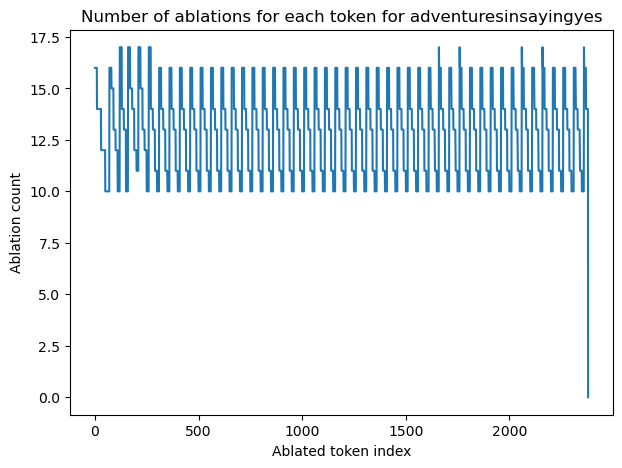

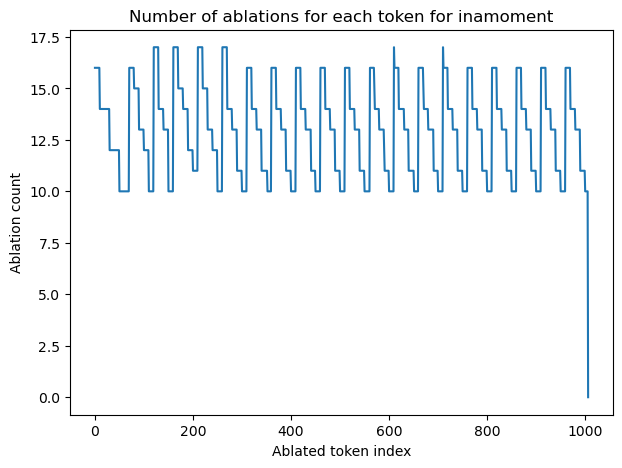

In [ ]:
target_ablation_lengths = np.arange(10,160,20)
bos_token_tensor = torch.Tensor([tokenizer.bos_token_id]).type(torch.int64)
min_pertoken_ablation = 10
for story in stories:
    story_tokens = torch.load(os.path.join(moth_output_dir,story,'tokens.pkl'))[0,1:]
    story_tokens = story_tokens.detach().cpu()
    story_stim_dir = os.path.join(moth_sliding_window_ablation_dir,story)
    # initialize ablation count
    new_ablation_count = np.zeros(story_tokens.shape)
    rare_ablation_indices = list(np.arange(story_tokens.shape[0]))
    save_dir = os.path.join(moth_sliding_window_ablation_dir,story)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    # index arrays all assume there's no BOS token, ie tokens[1:]
    future_index_start_in_original = [] # start index of tokens coming after the ablated tokens in the original token tensor 
    future_index_start_in_ablated=[] # start index of tokens coming after the ablated tokens in the ablated token tensor 
    post_ablation_tokens = [] # tokens after ablating each event
    ablated_tokens = []
    actual_ablation_start_indices = []
    ablation_token_lengths = []
    
    # the start token index of the last word. Tokens >= this index won't be ablated, so don't count them 
    last_word_ind = len(story_tokens)-1
    while model_initial_char not in tokenizer.convert_ids_to_tokens([story_tokens[last_word_ind]])[0]:
        last_word_ind = last_word_ind-1
    for ii in range(last_word_ind,len(story_tokens)):
        if ii in rare_ablation_indices:
            rare_ablation_indices.remove(ii)
            
    # use idx in rare_ablation_indices as start of ablations
    
    while len(rare_ablation_indices)>0:
        # make sure the start of ablation preserves word boundary 
        start_ablation_idx = rare_ablation_indices[0]
        this_token_txt = tokenizer.convert_ids_to_tokens([story_tokens[start_ablation_idx]])[0]
        while model_initial_char not in this_token_txt and start_ablation_idx>=1:
            start_ablation_idx-=1
            this_token_txt = tokenizer.convert_ids_to_tokens([story_tokens[start_ablation_idx]])[0]
        assert start_ablation_idx>=0
        for ablation_token_len in target_ablation_lengths:
                
            # make sure the end of ablation preserves word boundary 
            # if the min ablation length is already longer than the end of the text, 
            # and this ablation length is longer than min, then continue 
            if ablation_token_len > min(target_ablation_lengths) and start_ablation_idx+min(target_ablation_lengths)>=story_tokens.shape[0]:
                continue
            end_ablation_idx = start_ablation_idx+ablation_token_len
            # clip end_ablation_idx as the token before the end of text 
            if end_ablation_idx>=story_tokens.shape[0]:
                end_ablation_idx = story_tokens.shape[0]-1
            future_first_token = tokenizer.convert_ids_to_tokens([story_tokens[end_ablation_idx]])[0]
            # if this violates word boundary, increase the end ablation idx 
            while model_initial_char not in future_first_token and end_ablation_idx<story_tokens.shape[0]-1:
                end_ablation_idx+=1
                future_first_token = tokenizer.convert_ids_to_tokens([story_tokens[end_ablation_idx]])[0]
            # if we've reached the end and still violates word boundary, decrease the end ablation idx 
            while model_initial_char not in future_first_token and end_ablation_idx>start_ablation_idx:
                end_ablation_idx-=1
                future_first_token = tokenizer.convert_ids_to_tokens([story_tokens[end_ablation_idx]])[0]
            assert model_initial_char in future_first_token,'ablation must respect word boundary'
            actual_ablation_length = end_ablation_idx-start_ablation_idx
            ablation_token_lengths.append(actual_ablation_length)
            this_window_tokens = story_tokens[start_ablation_idx:end_ablation_idx]
            
            # check if this ablation is already made 
            for ablations in ablated_tokens:
                if ablations.shape == this_window_tokens.shape:
                    if torch.allclose(ablations,this_window_tokens):
                        continue
            
            if start_ablation_idx == 0:
                token_after_ablation = story_tokens[end_ablation_idx:]
                future_index_start_in_ablated.append(0)
            else: 
                first_chunk = story_tokens[:start_ablation_idx]
                second_chunk = story_tokens[end_ablation_idx:]
                token_after_ablation = torch.concat((first_chunk,second_chunk))
                future_index_start_in_ablated.append(len(first_chunk))
            future_index_start_in_original.append(end_ablation_idx) 
            
            assert torch.equal(story_tokens[future_index_start_in_original[-1]:],token_after_ablation[future_index_start_in_ablated[-1]:]),'future tokens must be equal in the two cases'
            # add bos
            token_after_ablation = torch.concat((bos_token_tensor,token_after_ablation))
            post_ablation_tokens.append(token_after_ablation)
            ablated_tokens.append(this_window_tokens)
            actual_ablation_start_indices.append(start_ablation_idx)
            
            in_tokens_idx = np.arange(start_ablation_idx,end_ablation_idx)
            new_ablation_count[in_tokens_idx]+=1
            rare_ablation_indices = list(np.where(new_ablation_count<min_pertoken_ablation)[0])
            for ii in range(last_word_ind,len(story_tokens)):
                if ii in rare_ablation_indices:
                    rare_ablation_indices.remove(ii)
            
        
    story_ablation_stim = {
        'future_index_start_in_original':future_index_start_in_original,
        'future_index_start_in_ablated':future_index_start_in_ablated,
        'ablated_token_len':ablation_token_lengths,
        'post_ablation_tokens':post_ablation_tokens,
        'ablated_tokens':ablated_tokens,
        'ablation_start_indices':actual_ablation_start_indices
        } 
#     for start_ind_count,ablation_start_index in enumerate(actual_ablation_start_indices):
#             # indices of ablated tokens 
#         in_tokens = np.arange(ablation_start_index,ablation_start_index+ablation_token_lengths[start_ind_count])
#         new_ablation_count[in_tokens]+=1
    with open(os.path.join(story_stim_dir,'ablation_stim_count_balanced.pkl'),'wb') as f:
        pickle.dump(story_ablation_stim,f)
    xx = np.arange(new_ablation_count.shape[0])
    fig,ax = plt.subplots(figsize = (7,5))
    ax.plot(xx,new_ablation_count)
    ax.set_title('Number of ablations for each token for %s'%story)
    ax.set_xlabel('Ablated token index')
    ax.set_ylabel('Ablation count')